In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mne
!pip install mne[hdf5]
!pip install madmom
!pip install ffmpeg
!pip install mir_eval

     |████████████████████████████████| 7.5 MB 9.4 MB/s 
     |████████████████████████████████| 20.0 MB 113 kB/s 
     |████████████████████████████████| 51 kB 7.2 MB/s 
  Created wheel for madmom: filename=madmom-0.16.1-cp37-cp37m-linux_x86_64.whl size=20935874 sha256=0399526869bf2ee0336abb04f57f9dd60c5f03a303983ed2146fc647c900862a
  Stored in directory: /root/.cache/pip/wheels/af/90/61/393ceef814b55b12d1b59b5ed3a2b2a3457a55d39b7363b975
Successfully built madmom
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6084 sha256=4b8be3c5a24f13c852cb576305324d82536eca77288801db15fbc0bf9a18346f
  Stored in directory: /root/.cache/pip/wheels/64/80/6e/caa3e16deb0267c3cbfd36862058a724144e19fdb9eb03af0f
Successfully built ffmpeg
     |████████████████████████████████| 90 kB 5.3 MB/s 
  Created wheel for mir-eval: filename=mir_eval-0.7-py3-none-any.whl size=100721 sha256=e3d2020c786b438852f7ffc6d21f7c855bffe492736392da8d555038bbfc7455
  Stored in directory: /root/.cache/pip/wh

In [ ]:
from scipy import io
import os
import numpy as np
from sklearn.metrics import roc_auc_score
import mne
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score

# from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torchaudio
# import wandb
import madmom
import madmom.features.beats
import madmom.features.onsets
import mir_eval
import ffmpeg
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc
import zipfile
import pandas as pd
from tqdm import tqdm
import os
import datetime


In [ ]:
data_folder='/content/drive/MyDrive/CMU/11785 Project/data'

### Restructuring the EEG folders

In [ ]:
timestamps = np.load(data_folder+'/ground_truths/timestamps.npy',allow_pickle=True)
len(timestamps)

10

In [ ]:
one_hot = np.load(data_folder+'/ground_truths/one_hot.npy',allow_pickle=True)
one_hot.shape

(10, 37500)

In [ ]:
data = io.loadmat(data_folder+'/users_mat/user0_restructured.mat')

In [ ]:
EEG = data['data']
EEG.shape

(10, 125, 37500)

In [ ]:
from scipy import io
loaded = io.loadmat(data_folder +'/users_mat/user0_restructured.mat',  struct_as_record=True)

# loaded = io.loadmat('/content/song21_Imputed.mat',  struct_as_record=True)
print(loaded.keys())
# dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])

dict_keys(['__header__', '__version__', '__globals__', 'data', 'user'])


### Previous Datasets

In [ ]:
# class UserDataset(torch.utils.data.Dataset):
#      def __init__(self, data_path, partition= "train", user_id = "0"): # You can use partition to specify train or dev

#         self.X_dir = data_path + "/users_mat/" # TODO: get mfcc directory path
#         self.Y_dir = data_path + "/ground_truths/" # TODO: get transcript path

#         self.X_files = os.listdir(self.X_dir)# TODO: list files in the mfcc directory
#         print(self.X_files)
#         if partition == 'train':
#             self.X_files = [f for f in self.X_files if user_id not in f]
#             val = 19
#         else:
#             self.X_files = [f for f in self.X_files if user_id in f]
#             val = 1
        
#         self.Y_onehot = np.load(data_path+'/ground_truths/one_hot.npy')
#         self.Y_timestamps = np.load(data_path+'/ground_truths/timestamps.npy',allow_pickle=True)
#         # self.Y_files = os.listdir(self.Y_dir) # TODO: list files in the transcript directory
#         self.XXX = []
#         self.YYY = []
  

#         for x_file in self.X_files:
#             Xtemp =  io.loadmat(data_folder+'/users_mat/'+x_file)
#             data = Xtemp['data']
#             data = mne.filter.filter_data(data,sfreq=100,l_freq=0.1,h_freq = 40)
#             for i in data:
#               #print("1",i.shape)
#               temp = np.reshape(i,(300,125,125))
#               #print("2",temp.shape)
#               split_temp = np.split(temp,300)
#               #print(len(split_temp))
#               #print("3",split_temp[0].shape)
#               self.XXX.extend(split_temp)
            
            

#             for i in self.Y_onehot:
#                 temp = np.split(i, 300)
#                 #print(len(temp))
#                 self.YYY.extend(temp)
              
        

#         print(len(self.YYY))
#         print(len(self.XXX))


#         pass

#      def __len__(self):
#         return len(self.X_files)

#      def __getitem__(self, ind):

#         return self.XXX[ind], self.YYY[ind]

In [ ]:
# users = UserDataset(data_folder, partition= "train", user_id = "user0")
# print(users[0])

In [ ]:
# class UserRNNValidDataset(torch.utils.data.Dataset):
#     def __init__(self, data_path, user_id = "0"): # You can use partition to specify train or dev
#         self.X_dir = data_path + "/users_mat/" # TODO: get mfcc directory path
#         self.Y_dir = data_path + "/ground_truths/" # TODO: get transcript path

#         self.X_files = os.listdir(self.X_dir)# TODO: list files in the mfcc directory
#         self.X_files = [f for f in self.X_files if user_id in f]
#         val = 1
#         print(self.X_files)
        
#         self.Y_onehot = np.load(data_path+'/ground_truths/one_hot.npy')
#         self.Y_timestamps = np.load(data_path+'/ground_truths/timestamps.npy',allow_pickle=True)
#         # self.Y_files = os.listdir(self.Y_dir)# TODO: list files in the transcript directory
#         self.XXX = []
#         self.YYY = []
        
#         for x_file in tqdm(self.X_files):
#             Xtemp =  io.loadmat(data_folder+'/users_mat/'+x_file)
#             data = Xtemp['data']
#             data = mne.filter.filter_data(data,sfreq=100,l_freq=0.1,h_freq = 40)
#             for i in data:
#                 x = i.T
#                 # temp = np.reshape(i,(300,125,125))
#                 # split_temp = np.split(temp,300)
#                 self.XXX.append(x)


#             for i in self.Y_onehot:
#                 # y = np.reshape(i,(300,125))
#                 # temp = np.split(i, 300)
#                 self.YYY.append(i)

#                 # self.YYY.extend(temp)

#         assert(len(self.YYY) == len(self.XXX))

#     def __len__(self):
#         return len(self.XXX)

#     def __getitem__(self, ind):
#         return self.XXX[ind], self.YYY[ind]
    
#     def collate_fn(batch):
#         batch_x = [torch.from_numpy(x) for x,y in batch]
#         batch_y = [torch.from_numpy(y) for x,y in batch]

#         return torch.stack(batch_x,dim=0).squeeze(dim=0),torch.stack(batch_y,dim=0).squeeze(dim=0)

In [ ]:
# class UserRNNDataset(torch.utils.data.Dataset):
#     def __init__(self, data_path, partition= "train", user_id = "0",context=0): # You can use partition to specify train or dev
#         self.X_dir = data_path + "/users_mat/" # TODO: get mfcc directory path
#         self.Y_dir = data_path + "/ground_truths/" # TODO: get transcript path
#         self.context = context
#         self.X_files = os.listdir(self.X_dir)# TODO: list files in the mfcc directory
#         print(user_id)
#         if partition == 'train':
#             self.X_files = [f for f in self.X_files if user_id not in f]
#             val = 19
#         else:
#             self.X_files = [f for f in self.X_files if user_id in f]
#             val = 1
#         print(self.X_files)
        
#         self.Y_onehot = np.load(data_path+'/ground_truths/one_hot.npy')
#         self.Y_timestamps = np.load(data_path+'/ground_truths/timestamps.npy',allow_pickle=True)
#         # self.Y_files = os.listdir(self.Y_dir)# TODO: list files in the transcript directory
#         XXX = []
#         self.YYY = []
        
#         for x_file in self.X_files:
#             Xtemp =  io.loadmat(data_folder+'/users_mat/'+x_file)
#             data = Xtemp['data']
#             data = mne.filter.filter_data(data,sfreq=100,l_freq=0.1,h_freq = 40)
#             for i in data:
#                 x = i.T
#                 temp = np.reshape(i,(300,125,125))
#                 split_temp = np.split(temp,300)
#                 XXX.extend(split_temp)
            
#             del Xtemp,data

#             for i in self.Y_onehot:
#                 y = np.reshape(i,(300,125))
#                 temp = np.split(i, 300)
#                 self.YYY.extend(temp)

#         self.XX =np.array(XXX)
#         # print(self.XX.shape)
#         if context!=0:
#             self.add_blocks = context//125 + 1
#             self.XX = np.pad(self.XX,((self.add_blocks,self.add_blocks),(0,0),(0,0),(0,0)))
#             # print("post pad",self.XX.shape)
        
#         # assert(len(self.YYY) == len(self.XXX))

#     def __len__(self):
#         return len(self.YYY)

#     def __getitem__(self, ind):
#         if self.context!=0:
#             extracted = self.XX[ind:ind+(self.add_blocks*2)+1,0]
#             pre_x = extracted[0,-self.context%125:,:]
#             post_x = extracted[-1,:self.context%125,:]
#             # print("pre",pre_x.shape)
#             # print("post",post_x.shape)
#             middle_x = extracted[1:-1,:,:].reshape((-1,125))
#             # print("middle",middle_x.shape)
#             final_x = np.vstack((pre_x,middle_x,post_x))
#             # print('final_x',final_x.shape)
#             return final_x,self.YYY[ind]
#         else:
#             return self.XXX[ind], self.YYY[ind]
    
#     def collate_fn(batch):
#         batch_x = [torch.from_numpy(x) for x,y in batch]
#         batch_y = [torch.from_numpy(y) for x,y in batch]

#         return torch.stack(batch_x,dim=0).squeeze(),torch.stack(batch_y,dim=0).squeeze()

### CNN Dataset

In [ ]:
class UserCNNDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, partition= "train", user_id = "0",context=0):
        self.X_dir = data_path + "/users_mat/"
        self.Y_dir = data_path + "/ground_truths/"
        self.context = context
        self.X_files = os.listdir(self.X_dir)

        if partition == 'train':
            self.X_files = [f for f in self.X_files if user_id not in f]
            val = 19
        else:
            self.X_files = [f for f in self.X_files if user_id in f]
            val = 1
        
        self.Y_onehot = np.load(data_path+'/ground_truths/one_hot.npy')
        self.Y_timestamps = np.load(data_path+'/ground_truths/timestamps.npy',allow_pickle=True)

        XXX = []
        self.YYY = []
        
        for x_file in self.X_files:
            Xtemp =  io.loadmat(data_folder+'/users_mat/'+x_file)
            data = Xtemp['data']
            data = mne.filter.filter_data(data,sfreq=100,l_freq=0.1,h_freq = 40)
            for i in data:
                x = i.T
                temp = np.reshape(i,(300,125,125))
                split_temp = np.split(temp,300)
                XXX.extend(split_temp)
            
            del Xtemp,data

            for i in self.Y_onehot:
                y = np.reshape(i,(300,125))
                temp = np.split(i, 300)
                self.YYY.extend(temp)

        self.XX = np.array(XXX)

        # print(self.XX.shape)
        if context != 0:
            self.add_blocks = context//125 + 1
            self.XX = np.pad(self.XX,((self.add_blocks,self.add_blocks),(0,0),(0,0),(0,0)))
            # print("post pad",self.XX.shape)
        
        # assert(len(self.YYY) == len(self.XXX))

    def __len__(self):
        return len(self.YYY)

    def __getitem__(self, ind):
        if self.context!=0:
            extracted = self.XX[ind:ind+(self.add_blocks*2)+1,0]
            pre_x = extracted[0,-self.context%125:,:]
            post_x = extracted[-1,:self.context%125,:]
            # print("pre",pre_x.shape)
            # print("post",post_x.shape)
            middle_x = extracted[1:-1,:,:].reshape((-1,125))
            # print("middle",middle_x.shape)
            final_x = np.vstack((pre_x,middle_x,post_x))
            # print('final_x',final_x.shape)

            return final_x,self.YYY[ind]
        else:
            return self.XXX[ind], self.YYY[ind]
    
    def collate_fn(batch):
        batch_x = [torch.from_numpy(x) for x,y in batch]
        batch_y = [torch.from_numpy(y) for x,y in batch]

        return torch.stack(batch_x,dim=0).squeeze(),torch.stack(batch_y,dim=0).squeeze()


### Data loader

In [ ]:
user_id = 0
context = 30
train_dataset = UserCNNDataset(data_folder,'train','user'+str(user_id),context = context)
val_dataset = UserCNNDataset(data_folder,partition="valid",user_id='user'+str(user_id),context = context)
train_loader =torch.utils.data.DataLoader(train_dataset,batch_size=32,collate_fn = UserCNNDataset.collate_fn,shuffle=True,num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=32,collate_fn = UserCNNDataset.collate_fn,shuffle=False,num_workers=4)

Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (33.010 sec)

Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 

In [ ]:
val_dataset[0]

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 4.80888948,  1.43631687, -0.08459435, ...,  1.57763966,
         -1.56215781,  2.7852547 ],
        [ 2.32875625,  2.82917061,  3.71515616, ...,  4.68066486,
          1.91258036,  1.75669337],
        [ 2.01937436,  4.78414525,  5.45246382, ...,  0.53407885,
         -1.66865427, -2.49434733]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
val_dataset[0][0].shape

(185, 125)

### Network

In [ ]:
# size calculation for Conv1d
# torch.Size([32, 205, 125]) # input shape

L_in = 3
padding = 0
dilation = 1
kernel_size = 2 * context + 1
stride = 1
L_out = (L_in + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1
L_out

-57.0

In [ ]:
class Network(torch.nn.Module):
    def __init__(self,context=0):
        super(Network, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=125, out_channels=2500, kernel_size = 2*context+1, padding="valid", stride=1, groups = 125)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=2500, out_channels=125, kernel_size = 2*context+1, padding="valid", stride=1, groups = 125)
        self.relu2 = nn.ReLU()
        # self.conv3 = nn.Conv1d(in_channels=5000, out_channels=125, kernel_size = 2*context+1, padding="valid", stride=1, groups = 125)
        # self.relu3 = nn.ReLU()
        # self.conv4 = nn.Conv1d(in_channels=7500, out_channels=5000, kernel_size = 2*context+1, padding="valid", stride=1, groups = 125)
        # self.relu4 = nn.ReLU()
        self.classifier = nn.Linear(in_features=65, out_features=1) # try with 125 output

    def forward(self, x):
        x = self.conv1(torch.permute(x, (0,2,1)))
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.relu2(x)

        # x = self.conv3(x)
        # x = self.relu3(x)

        # x = self.conv4(x)
        # x = self.relu4(x)

        x = self.classifier(x)

        return x

In [ ]:
# del model
model = Network(context=context).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)

In [ ]:
for batch_idx, data in enumerate(val_loader):
    x = data[0].cuda()
    y = data[1].cuda()    
    # print('x.shape',x.shape)
    # print('y.shape',y.shape)

    out = model(x.float())

    print('out.shape', out.shape)
    print(out.flatten().shape)
    print(y.flatten().shape)
    # print(min(out),max(out))
    out2 = nn.Sigmoid()(out)

    print(roc_auc_score(y.cpu().detach().numpy().flatten(), out2.cpu().detach().numpy().flatten()))
    break

out.shape torch.Size([32, 125, 1])
torch.Size([4000])
torch.Size([4000])
0.533265306122449


In [ ]:
out

tensor([[[ 0.3423],
         [ 0.6994],
         [-0.1536],
         ...,
         [ 0.1359],
         [ 0.2284],
         [-0.2145]],

        [[-0.2554],
         [-0.0811],
         [-0.1591],
         ...,
         [ 0.0719],
         [ 0.4849],
         [-0.2418]],

        [[ 0.1502],
         [ 0.4308],
         [ 0.1387],
         ...,
         [ 0.1788],
         [ 0.0909],
         [-0.1807]],

        ...,

        [[ 0.3175],
         [ 0.0974],
         [ 0.1438],
         ...,
         [-0.2740],
         [ 0.1175],
         [ 0.1094]],

        [[-0.3287],
         [ 0.3177],
         [-0.2744],
         ...,
         [ 0.0843],
         [ 0.0353],
         [ 0.3806]],

        [[ 0.3303],
         [ 0.2242],
         [ 0.5769],
         ...,
         [-0.1048],
         [-0.0319],
         [ 0.5258]]], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
model(x.float()).shape

torch.Size([32, 125, 1])

### Validation

In [ ]:
def validate(model,val_loader,criterion):
    model.eval()

    f1=[]

    recall=[]
    precision=[]
    total_val_loss = 0
    ground_truth=np.empty((1,0))
    predictions = np.empty((1,0))
    total_raw_score=0

    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Validation')
    for idx,(x,y) in tqdm(enumerate(val_loader)):
        ground_truth = np.append(ground_truth,y.reshape(1,-1))

        x = x.float().cuda()
        y = y.float().cuda()

        with torch.no_grad():
            pd_one_hot = model(x)
            predictions = np.append(predictions,nn.Sigmoid()(pd_one_hot).squeeze().cpu().detach().numpy().reshape(1,-1))

            val_loss = criterion(pd_one_hot.squeeze(),y)

            y_np = y.cpu().numpy()

            pred_np = pd_one_hot.cpu().detach().numpy()
            total_raw_score += roc_auc_score(y_np.flatten(),pred_np.flatten())
        total_val_loss +=val_loss

        batch_bar.set_postfix(roc_score="{:.04f}".format(float(total_raw_score / (idx + 1))),loss="{:.04f}".format(float(total_val_loss / (idx + 1))), lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        batch_bar.update()

        torch.cuda.empty_cache()

    for idx in range(10):
        gt_ts = val_loader.dataset.Y_timestamps[idx]
        song_pred = predictions[idx*37500:(idx+1)*37500]

        out = madmom.features.onsets.peak_picking(song_pred,0.059)
        predicted_ts = out/125
        print("# of ground truths:", len(gt_ts))
        print("# of predicted:", len(predicted_ts))
        if len(predicted_ts)==0:
            F,P,R = 0.0,0.0,0.0
        else:
            F,P,R = mir_eval.onset.f_measure(gt_ts,predicted_ts,window=1)
        
        f1.append(F)
        precision.append(P)
        recall.append(R)

    batch_bar.close()
    model.train()

    return f1, precision, recall, total_val_loss/len(val_loader)


In [ ]:
epoch = 10
scores = {"f":[],'p':[],'r':[]}

### Training the model

In [ ]:
for e in range(epoch):
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    total_loss = 0

    for idx,data in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x=data[0].float().cuda()
        y=data[1].float().cuda()
        out = model(x)
        out=out.squeeze()
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()
        total_loss += loss

        batch_bar.set_postfix(loss="{:.04f}".format(float(total_loss / (idx + 1))), lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        batch_bar.update()

        del data, x, y, out, loss
        torch.cuda.empty_cache()
    batch_bar.close()

    f, p, r, val_loss  = validate(model,val_loader,criterion)
    scores['f'].append(f)
    scores['p'].append(p)
    scores['r'].append(r)

    print("Epoch {}/{}: Train Loss {:.04f}, Learning Rate {:.04f}, Validation Loss {:.04f}, F1 Score {:.04f}, Precision {:.04f}, Recall {:.04f}".format(
        e,
        epoch,
        float(total_loss / (len(train_loader))),
        float(optimizer.param_groups[0]['lr']),val_loss,np.mean(f),np.mean(p),np.mean(r)))

Validation:  96%|█████████▌| 90/94 [00:02<00:00, 48.32it/s, loss=0.2858, lr=0.0010, roc_score=0.4995]
94it [00:02, 42.60it/s]


# of ground truths: 1151
# of predicted: 37200
# of ground truths: 1622
# of predicted: 37200
# of ground truths: 1312
# of predicted: 37200
# of ground truths: 941
# of predicted: 37200
# of ground truths: 1823
# of predicted: 37200
# of ground truths: 1565
# of predicted: 37200
# of ground truths: 1509
# of predicted: 37200
# of ground truths: 1775
# of predicted: 37200
# of ground truths: 2124
# of predicted: 37200
# of ground truths: 2239
# of predicted: 37200


Epoch 0/10: Train Loss 0.4478, Learning Rate 0.0010, Validation Loss 0.2864, F1 Score 0.0826, Precision 0.0432, Recall 1.0000


Validation:  98%|█████████▊| 92/94 [00:02<00:00, 50.56it/s, loss=0.1960, lr=0.0010, roc_score=0.4996]
94it [00:02, 43.90it/s]


# of ground truths: 1151
# of predicted: 37199
# of ground truths: 1622
# of predicted: 37195
# of ground truths: 1312
# of predicted: 37193
# of ground truths: 941
# of predicted: 37192
# of ground truths: 1823
# of predicted: 37197
# of ground truths: 1565
# of predicted: 37193
# of ground truths: 1509
# of predicted: 37198
# of ground truths: 1775
# of predicted: 37195
# of ground truths: 2124
# of predicted: 37189
# of ground truths: 2239
# of predicted: 37199


Epoch 1/10: Train Loss 0.2301, Learning Rate 0.0010, Validation Loss 0.1961, F1 Score 0.0826, Precision 0.0432, Recall 1.0000


Validation:  98%|█████████▊| 92/94 [00:02<00:00, 52.16it/s, loss=0.1785, lr=0.0010, roc_score=0.5003]
94it [00:02, 45.51it/s]


# of ground truths: 1151
# of predicted: 26
# of ground truths: 1622
# of predicted: 21
# of ground truths: 1312
# of predicted: 38
# of ground truths: 941
# of predicted: 31
# of ground truths: 1823
# of predicted: 29
# of ground truths: 1565
# of predicted: 36
# of ground truths: 1509
# of predicted: 25
# of ground truths: 1775
# of predicted: 32
# of ground truths: 2124
# of predicted: 20
# of ground truths: 2239
# of predicted: 26
Epoch 2/10: Train Loss 0.1847, Learning Rate 0.0010, Validation Loss 0.1786, F1 Score 0.0355, Precision 0.9394, Recall 0.0181


Validation:  99%|█████████▉| 93/94 [00:02<00:00, 50.81it/s, loss=0.1769, lr=0.0010, roc_score=0.5001]
94it [00:02, 44.35it/s]


# of ground truths: 1151
# of predicted: 21
# of ground truths: 1622
# of predicted: 5
# of ground truths: 1312
# of predicted: 22
# of ground truths: 941
# of predicted: 37
# of ground truths: 1823
# of predicted: 26
# of ground truths: 1565
# of predicted: 12
# of ground truths: 1509
# of predicted: 17
# of ground truths: 1775
# of predicted: 13
# of ground truths: 2124
# of predicted: 17
# of ground truths: 2239
# of predicted: 16
Epoch 3/10: Train Loss 0.1773, Learning Rate 0.0010, Validation Loss 0.1769, F1 Score 0.0243, Precision 0.9357, Recall 0.0124


Validation:  99%|█████████▉| 93/94 [00:02<00:00, 50.97it/s, loss=0.1769, lr=0.0010, roc_score=0.5001]
94it [00:02, 44.69it/s]


# of ground truths: 1151
# of predicted: 23
# of ground truths: 1622
# of predicted: 12
# of ground truths: 1312
# of predicted: 12
# of ground truths: 941
# of predicted: 7
# of ground truths: 1823
# of predicted: 10
# of ground truths: 1565
# of predicted: 11
# of ground truths: 1509
# of predicted: 7
# of ground truths: 1775
# of predicted: 13
# of ground truths: 2124
# of predicted: 13
# of ground truths: 2239
# of predicted: 5
Epoch 4/10: Train Loss 0.1768, Learning Rate 0.0010, Validation Loss 0.1769, F1 Score 0.0142, Precision 0.9512, Recall 0.0072


Validation:  98%|█████████▊| 92/94 [00:02<00:00, 50.76it/s, loss=0.1767, lr=0.0010, roc_score=0.5000]
94it [00:02, 44.55it/s]


# of ground truths: 1151
# of predicted: 6
# of ground truths: 1622
# of predicted: 0
# of ground truths: 1312
# of predicted: 4
# of ground truths: 941
# of predicted: 0
# of ground truths: 1823
# of predicted: 2
# of ground truths: 1565
# of predicted: 0
# of ground truths: 1509
# of predicted: 1
# of ground truths: 1775
# of predicted: 3
# of ground truths: 2124
# of predicted: 1
# of ground truths: 2239
# of predicted: 0
Epoch 5/10: Train Loss 0.1768, Learning Rate 0.0010, Validation Loss 0.1769, F1 Score 0.0023, Precision 0.5833, Recall 0.0011


Validation:  94%|█████████▎| 88/94 [00:02<00:00, 50.44it/s, loss=0.1740, lr=0.0010, roc_score=0.4999]
94it [00:02, 45.73it/s]


# of ground truths: 1151
# of predicted: 0
# of ground truths: 1622
# of predicted: 1
# of ground truths: 1312
# of predicted: 0
# of ground truths: 941
# of predicted: 0
# of ground truths: 1823
# of predicted: 1
# of ground truths: 1565
# of predicted: 1
# of ground truths: 1509
# of predicted: 0
# of ground truths: 1775
# of predicted: 0
# of ground truths: 2124
# of predicted: 0
# of ground truths: 2239
# of predicted: 0
Epoch 6/10: Train Loss 0.1768, Learning Rate 0.0010, Validation Loss 0.1769, F1 Score 0.0004, Precision 0.3000, Recall 0.0002


Validation:  94%|█████████▎| 88/94 [00:02<00:00, 50.24it/s, loss=0.1740, lr=0.0010, roc_score=0.4999]
94it [00:02, 44.61it/s]


# of ground truths: 1151
# of predicted: 2
# of ground truths: 1622
# of predicted: 2
# of ground truths: 1312
# of predicted: 2
# of ground truths: 941
# of predicted: 0
# of ground truths: 1823
# of predicted: 2
# of ground truths: 1565
# of predicted: 6
# of ground truths: 1509
# of predicted: 1
# of ground truths: 1775
# of predicted: 0
# of ground truths: 2124
# of predicted: 1
# of ground truths: 2239
# of predicted: 0
Epoch 7/10: Train Loss 0.1768, Learning Rate 0.0010, Validation Loss 0.1769, F1 Score 0.0021, Precision 0.7000, Recall 0.0011


Validation:  99%|█████████▉| 93/94 [00:02<00:00, 51.02it/s, loss=0.1769, lr=0.0010, roc_score=0.4999]
94it [00:02, 44.50it/s]


# of ground truths: 1151
# of predicted: 0
# of ground truths: 1622
# of predicted: 0
# of ground truths: 1312
# of predicted: 1
# of ground truths: 941
# of predicted: 0
# of ground truths: 1823
# of predicted: 0
# of ground truths: 1565
# of predicted: 2
# of ground truths: 1509
# of predicted: 0
# of ground truths: 1775
# of predicted: 0
# of ground truths: 2124
# of predicted: 0
# of ground truths: 2239
# of predicted: 1
Epoch 8/10: Train Loss 0.1768, Learning Rate 0.0010, Validation Loss 0.1769, F1 Score 0.0005, Precision 0.3000, Recall 0.0002


Validation:  98%|█████████▊| 92/94 [00:02<00:00, 50.05it/s, loss=0.1767, lr=0.0010, roc_score=0.5000]
94it [00:02, 43.76it/s]
                                                                                                     

# of ground truths: 1151
# of predicted: 2
# of ground truths: 1622
# of predicted: 3
# of ground truths: 1312
# of predicted: 1
# of ground truths: 941
# of predicted: 0
# of ground truths: 1823
# of predicted: 1
# of ground truths: 1565
# of predicted: 4
# of ground truths: 1509
# of predicted: 1
# of ground truths: 1775
# of predicted: 1
# of ground truths: 2124
# of predicted: 0
# of ground truths: 2239
# of predicted: 1
Epoch 9/10: Train Loss 0.1768, Learning Rate 0.0010, Validation Loss 0.1769, F1 Score 0.0018, Precision 0.8000, Recall 0.0009


In [ ]:
out = validate(model, val_loader, criterion)

Validation:  94%|█████████▎| 88/94 [00:02<00:00, 55.00it/s, loss=0.1740, lr=0.0010, roc_score=0.5274]
94it [00:01, 48.72it/s]
                                                                                                     


1151
1456

1622
1128

1312
1175

941
1600

1823
1756

1565
1044

1509
1587

1775
1506

2124
1661

2239
1388


In [ ]:
out

([0.7203682393555813,
  0.7076363636363636,
  0.6698833936469643,
  0.7052341597796143,
  0.8393405979323832,
  0.6952855500191645,
  0.843669250645995,
  0.7698872295032002,
  0.7973579920739763,
  0.7394540942928041],
 [0.6449175824175825,
  0.8625886524822695,
  0.708936170212766,
  0.56,
  0.8553530751708428,
  0.8687739463601533,
  0.8229363579080026,
  0.8386454183266933,
  0.9084888621312462,
  0.9661383285302594],
 [0.8158123370981755,
  0.5998766954377311,
  0.6349085365853658,
  0.9521785334750266,
  0.8239166209544706,
  0.579552715654952,
  0.8654738237243207,
  0.7115492957746479,
  0.71045197740113,
  0.5989280928986155],
 tensor(0.1765, device='cuda:0'))

In [ ]:
val_dataset.Y_timestamps[0],val_dataset.Y_timestamps[1]

(array([  1.07,   1.91,   2.16, ..., 273.25, 273.81, 273.95]),
 array([  0.57,   0.98,   1.07, ..., 264.78, 264.9 , 265.  ]))

In [ ]:
val_dataset[0][1][1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [ ]:
val_dataset[1][1][0]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0.])

In [ ]:
a=np.array([0,3.7,4,4.1,0.1,2.3,2,0,0])

In [ ]:
out = madmom.features.onsets.peak_picking(a,0.5)

In [ ]:
out

array([3, 5])

In [ ]:
a=np.array([0,234,5685,23424])/125

In [ ]:
a

array([  0.   ,   1.872,  45.48 , 187.392])

In [ ]:
b =val_loader.dataset.Y_timestamps[0]

In [ ]:
mir_eval.onset.f_measure(b,
                                   a)

(0.0017316017316017314, 0.25, 0.0008688097306689834)

In [ ]:
dataset = UserRNNDataset(data_folder,partition='val',user_id="user0")

['user0_restructured.mat']


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


In [ ]:
len(dataset)

10

In [ ]:
x,y = dataset[0]

In [ ]:
x.shape

(37500, 125)

In [ ]:
y.shape

(37500,)

In [ ]:
#dict_keys(['__header__', '__version__', '__globals__', 'data21', 'fs', 'subs21'])

dat = np.transpose(np.array(loaded['data21']), (2,0,1)) #Putting into 20 x 125 x N

print(dat.shape)
print(loaded['data21'].shape) #Actual Data
#(20 subjects, 125 channels and N time steps)
print(loaded['fs'].shape)
print(loaded['fs']) #fs is just for number of channels
print(loaded['subs21'].shape) #Subjects


#sfreq = loaded['data21'][125]
EEGdata   = dat
nsubjects, nchannels, ntimesteps = EEGdata.shape


(20, 125, 34795)
(125, 34795, 20)
(1, 1)
[[125]]
(1, 20)


In [ ]:
pad_length = 37500 - ntimesteps

EEGdata = np.pad(EEGdata, ((0,0) , (0,0), (0, pad_length)), constant_values=0)

print("padded EEG data shape: ", EEGdata.shape)

padded EEG data shape:  (20, 125, 37500)


In [ ]:
#Segment into one second blocks
split_EEGdata = np.dsplit(EEGdata, 300)
print(split_EEGdata[0].shape)

(20, 125, 125)


In [ ]:
#I think the split worked correctly?
print(len(split_EEGdata[0][0][0]))
print(len(split_EEGdata))

125
300


In [ ]:
#we filter the EEG data with a bandpass filter (0.1–
#40 Hz) and zero-pad the dataset uniformly to a length of 37500
#samples (5 min), since the longest song in the dataset is around
#five minutes long

!pip install eeg-filters



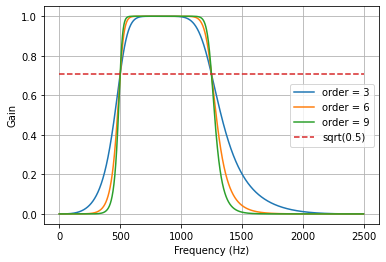

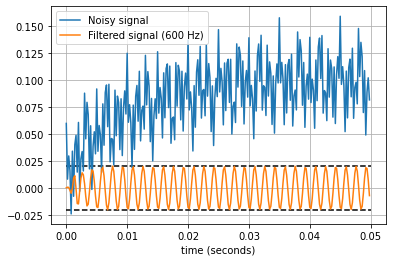

In [ ]:

from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 5000.0
lowcut = 500.0
highcut = 1250.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
          '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

# Filter a noisy signal.
T = 0.05
nsamples = T * fs
t = np.arange(0, nsamples) / fs
a = 0.02
f0 = 600.0
x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
x += a * np.cos(2 * np.pi * f0 * t + .11)
x += 0.03 * np.cos(2 * np.pi * 2000 * t)

#x = EEGdata[0]

plt.figure(2)
plt.clf()
plt.plot(t, x, label='Noisy signal')

y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
plt.xlabel('time (seconds)')
plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()


Attempting to Annotate Music with MADMOM ODF RNN

In [ ]:
import madmom
import madmom.features.beats
import madmom.features.onsets
import ffmpeg

In [ ]:
#from scipy.io import wavfile
#samplerate, data = wavfile.read('/content/first_fires.wav')

In [ ]:
#proc1.reset()
proc1 = madmom.features.onsets.OnsetPeakPickingProcessor(fps = 100) #What should fps be?
act1 = madmom.features.onsets.RNNOnsetProcessor()(data_folder + '/content/first_fires.wav') 
onset_values = proc1(act1) 
print(onset_values)
gt = np.zeros(37500)
idx_list=[]
for onset in (onset_values):
    idx_list.append(onset*125)
print(idx_list)
idx_list = np.array(idx_list)

idx_list = np.round(idx_list,0).astype('int64')
print(idx_list)

gt[idx_list] = 1

[  1.07   1.91   2.16 ... 273.25 273.81 273.95]


[133.75, 238.75, 270.0, 343.75, 406.25, 511.25, 612.5, 678.75, 785.0, 816.25, 892.5, 952.5, 1057.5, 1156.25, 1225.0, 1330.0, 1361.25, 1430.0, 1435.0, 1497.5, 1602.5, 1633.75, 1706.25, 1770.0, 1875.0, 1906.25, 1978.75, 2042.5, 2147.5, 2248.75, 2315.0, 2421.25, 2442.5, 2456.25, 2487.5, 2518.75, 2542.5, 2558.75, 2588.75, 2693.75, 2727.5, 2735.0, 2760.0, 2775.0, 2792.5, 2811.25, 2826.25, 2861.25, 2928.75, 2966.25, 3002.5, 3017.5, 3032.5, 3050.0, 3070.0, 3083.75, 3098.75, 3133.75, 3238.75, 3271.25, 3277.5, 3306.25, 3321.25, 3356.25, 3406.25, 3468.75, 3511.25, 3546.25, 3577.5, 3610.0, 3632.5, 3678.75, 3783.75, 3817.5, 3851.25, 3866.25, 3885.0, 3902.5, 3917.5, 3952.5, 4019.9999999999995, 4057.5, 4093.75, 4108.75, 4123.75, 4140.0, 4173.75, 4190.0, 4225.0, 4330.0, 4362.5, 4367.5, 4396.25, 4412.5, 4428.75, 4447.5, 4465.0, 4497.5, 4602.5, 4623.75, 4637.5, 4668.75, 4701.25, 4723.75, 4737.5, 4770.0, 4875.0, 4910.0, 4926.25, 4942.5, 4957.5, 4975.0, 4992.5, 5008.75, 5042.5, 5110.0, 5148.75, 5185.0, 5

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [ ]:
print(len(onset_values))

import os
import wave

with wave.open(data_folder + '/songs_wav/first_fires.wav', "rb") as wave_file:
  frame_rate = wave_file.getframerate()
print(frame_rate)

1151
48000


In [ ]:
#lmao this is so wrong

song_labels = np.zeros(37500)

for i in onset_values:
  song_labels[int(i)] = 1

In [ ]:
print(song_labels[-1000:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
split_song_labels = np.split(song_labels, 300)
print(split_song_labels[0].shape)

(125,)


In [ ]:
print(len(split_song_labels))

300


Fully Connected Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm2d
class Network(torch.nn.Module): #All your models should inherit from torch.nn.Module
    def __init__(self, context = 0):
        super(Network, self).__init__()
        # TODO: Please try different architectures
        
        layers = [
            nn.Linear(15625, 256),
            nn.ReLU(),
            nn.Linear(256, 125)]

        self.laysers = nn.Sequential(*layers)


    def forward(self, A0):
        x = self.laysers(A0)
        return x

In [ ]:
#train_loader = torch.utils.data.DataLoader(split_EEGdata, batch_size=50, shuffle=False)
out = Network(split_EEGdata[0].flatten())

In [ ]:
class ToyDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.XXX = np.arange(200).reshape(40,-1)
        self.YYY = self.XXX * 2

    def __len__(self):
        return len(self.XXX)

    def __getitem__(self, ind):
        return self.XXX[ind], self.YYY[ind]
    
    def collate_fn(batch):
        batch_x = [torch.from_numpy(x) for x,y in batch]
        batch_y = [torch.from_numpy(y) for x,y in batch]

        return torch.stack(batch_x,dim=0).squeeze(),torch.stack(batch_y,dim=0).squeeze()
    

In [ ]:
data = ToyDataset()

In [ ]:
data[0]

(array([0, 1, 2, 3, 4]), array([0, 2, 4, 6, 8]))

In [ ]:
loader = torch.torch.utils.data.DataLoader(data,batch_size=32,collate_fn = ToyDataset.collate_fn,shuffle=False,num_workers=4)

In [ ]:
final_y = np.empty((1,0))
for x,y in loader:
    print(x.reshape(1,-1))
    final_y = np.append(final_y,y.reshape(-1,1))

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])
tensor([[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])
tensor([[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]])
tensor([[45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]])
tensor([[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]])
tensor([[75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]])
tensor([[ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
         104]])
tensor([[105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
         119]])
tensor([[120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
         134]])
tensor([[135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
         149]])
tensor([[150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
         164]])
tensor([[165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
         179]])
tens

In [ ]:
final_y

array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
        66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.,  90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108.,
       110., 112., 114., 116., 118., 120., 122., 124., 126., 128., 130.,
       132., 134., 136., 138., 140., 142., 144., 146., 148., 150., 152.,
       154., 156., 158., 160., 162., 164., 166., 168., 170., 172., 174.,
       176., 178., 180., 182., 184., 186., 188., 190., 192., 194., 196.,
       198., 200., 202., 204., 206., 208., 210., 212., 214., 216., 218.,
       220., 222., 224., 226., 228., 230., 232., 234., 236., 238., 240.,
       242., 244., 246., 248., 250., 252., 254., 256., 258., 260., 262.,
       264., 266., 268., 270., 272., 274., 276., 278., 280., 282., 284.,
       286., 288., 290., 292., 294., 296., 298., 30

In [ ]:
from sklearn.metrics import f1_score


In [ ]:
y_pred = np.zeros((3,10))
y_true = np.ones((3,10))

In [ ]:
y_pred[1][4] = 1
y_pred[2][5] = 1
y_pred[0][4] = 1
y_pred[2][0] = 1
y_pred[0][0] = 1
y_pred[1][0] = 1
y_pred[0][4] = 1
y_pred[1][8] = 1


In [ ]:
y_true[1][8]=0
y_true[0][1]=0
y_true[0][1]=0
y_true[0][8]=0
y_true[2][4]=0
y_true[0][2]=0
y_true[1][7]=0


In [ ]:
f1_score(y_pred.flatten(),y_true.flatten())

0.3870967741935483

In [ ]:
a = np.arange(20).reshape(4,5)
b = np.arange(100,120).reshape(4,5)

In [ ]:
x=[]
x.append(a)
x.append(b)

In [ ]:
m = np.array(x)

In [ ]:
np.pad(m,((2,2),(0,0),(0,0)))

array([[[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   1,   2,   3,   4],
        [  5,   6,   7,   8,   9],
        [ 10,  11,  12,  13,  14],
        [ 15,  16,  17,  18,  19]],

       [[100, 101, 102, 103, 104],
        [105, 106, 107, 108, 109],
        [110, 111, 112, 113, 114],
        [115, 116, 117, 118, 119]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]]])

In [ ]:
a =np.arange(2*3*5).reshape(2,3,5)

In [ ]:
a

array([[[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]],

       [[15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24],
        [25, 26, 27, 28, 29]]])

In [ ]:
a = np.arange(8).reshape((2,4))
b = np.arange(12).reshape(3,4)
c = np.arange(8).reshape((2,4))


In [ ]:
b

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [ ]:
np.vstack((a,b,c)).shape

(7, 4)